<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [ ]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

In [ ]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

In [ ]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = []
for symbol in symbols:
    if "USD" in symbol.name:
        print("Yes ", symbol.name)
        t_symbol.append(symbol.name)

print(len(t_symbol))

In [ ]:
market = mt5.copy_rates_from_pos(t_symbol[10], mt5.TIMEFRAME_M30, 0, 99999)
display(market)
print(market.shape)
print(t_symbol[10])
t_s = t_symbol[10]

data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
df = pd.DataFrame(data, columns=["open", "high","low", "close"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)


In [ ]:
test_symbol = []
for t_s in t_symbol:
    market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_H1, 0, 99999)
    if(len(market) > 80000 ):
        data = []
        for i in range(len(market)):
            data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
        df = pd.DataFrame(data, columns=["open", "high","low", "close"])
        df.to_csv("Generated"+t_s+" dbot.csv", index=False)
        test_symbol.append(t_s)


In [ ]:

for t_s in test_symbol:
    market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_D1, 0, 1000)
    if(len(market) > 900):
        data = []
        for i in range(len(market)):
            data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
        df = pd.DataFrame(data, columns=["open", "high","low", "close"])
        df.to_csv("Generated"+t_s+" test.csv", index=False)



In [ ]:
import joblib

joblib.dump(t_symbol,"symbol.joblib")

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.10.1


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
# Get the list of all files and directories in the specified path

dir_contents = os.listdir(".")
t_symbol = joblib.load("symbol.joblib")

In [5]:
print(t_symbol)

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCHF', 'AUDUSD', 'NZDUSD', 'USDCAD', 'USDMXN', 'USDZAR', 'XAGUSD', 'XAUUSD', 'XBRUSD', 'XTIUSD', 'XNGUSD', 'BTCUSD', 'ETHUSD', 'LTCUSD', 'XRPUSD', 'BCHUSD', 'AAVEUSD', 'ADAUSD', 'ALGOUSD', 'ATOMUSD', 'AVAXUSD', 'AXSUSD', 'BNBUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'FILUSD', 'GRTUSD', 'ICPUSD', 'IOTAUSD', 'LINKUSD', 'LRCUSD', 'MANAUSD', 'NEARUSD', 'SOLUSD', 'UNIUSD', 'ZECUSD', 'ETCUSD', 'TRXUSD', 'FETUSD', 'ARBUSD', 'APTUSD', 'SUIUSD', 'USDDKK', 'USDCZK', 'USDHUF', 'USDNOK', 'USDPLN', 'USDSEK', 'USDSGD', 'USDHKD', 'USDCNH', 'USDTRY', 'XBRUSD.Daily', 'XTIUSD.Daily', 'BTCUSD.Daily', 'ETHUSD.Daily', 'XRPUSD.Daily', 'LTCUSD.Daily', 'BCHUSD.Daily', 'LINKUSD.Daily', 'SOLUSD.Daily']


In [ ]:
#t_symbol = ["EURUSD","AUDUSD","GBPUSD","USDCAD"]

In [6]:

# Filter the list to include only files, not directories
# os.path.join is used to create a full path for isfile() to check
files = [item for item in dir_contents]

file_target = []
test_target = []

for filename in files:
    for t_s in t_symbol:
        if t_s in filename  and "dbot.csv" in filename:
            print(filename)
            file_target.append(filename)
            test_target.append(filename.replace("dbot","test"))

print("----------------------------------------------------")

print(len(file_target))
print(len(test_target))
train_dfs = []
for f_t in file_target:
    train_dfs.append(pd.read_csv(f_t))
try:
    train_dfs_test = []
    for f_t in test_target:
        train_dfs_test.append(pd.read_csv(f_t))
except:
    pass

GeneratedAUDUSD dbot.csv
GeneratedEURUSD dbot.csv
GeneratedGBPUSD dbot.csv
GeneratedNZDUSD dbot.csv
GeneratedUSDCAD dbot.csv
GeneratedUSDCHF dbot.csv
GeneratedUSDJPY dbot.csv
GeneratedUSDMXN dbot.csv
GeneratedUSDZAR dbot.csv
GeneratedXAUUSD dbot.csv
----------------------------------------------------
10
10


In [ ]:
display(train_dfs[0])

In [ ]:
display(train_dfs_test[0])

In [ ]:
print(train_dfs[0].values[:,-1:])

In [7]:
def create_sequences(data_scaled, seq_len, pred_steps = 5):
    """
    data_scaled: np.array shaped (n_rows, n_features)
    returns X (n_samples, seq_len, n_features), y (n_samples, n_features)
    where y is the row immediately following the window.
    """
    X, y = [], []
    n_rows = data_scaled.shape[0]
    for i in range(n_rows - seq_len - pred_steps + 1):
        X.append(data_scaled[i:i+seq_len])
        y.append(data_scaled[i+seq_len : i + seq_len+pred_steps, -1])
    X = np.array(X)
    y = np.array(y)
    return X, y





In [51]:
n = 0

In [52]:
m_label = file_target[n].replace("dbot.csv","")
train_df = train_dfs[n]
#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 240 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape

X, y = create_sequences(train_df.values, SEQ_LEN, 5)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)
#X1, y1 = create_sequences(train_df.values, SEQ_LEN, 5)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

n_samples = X.shape[0]


GeneratedAUDUSD 


In [37]:
X, y = preprocess_and_save_scalers(X, y)
#X1, y1 = transform_data(X1, y1)

Scaler for X saved to 'scaler_x.joblib'
Scaler for Y saved to 'scaler_y.joblib'


In [53]:
print(X[-1])

[[0.65806 0.65811 0.65761 0.65792]
 [0.65793 0.65827 0.65783 0.6582 ]
 [0.6582  0.65832 0.65802 0.6581 ]
 [0.65805 0.65814 0.65795 0.65798]
 [0.65798 0.65854 0.65798 0.6585 ]
 [0.65851 0.65858 0.65831 0.65852]
 [0.65854 0.65931 0.65836 0.65923]
 [0.65924 0.65937 0.65835 0.65866]
 [0.65867 0.65977 0.65867 0.65976]
 [0.65976 0.65995 0.65956 0.65985]
 [0.65986 0.65999 0.65962 0.6597 ]
 [0.65969 0.65976 0.65896 0.65939]
 [0.65941 0.65997 0.65906 0.6594 ]
 [0.65939 0.6594  0.65847 0.65848]
 [0.6585  0.66001 0.65845 0.65977]
 [0.6598  0.66032 0.65951 0.65978]
 [0.65979 0.65996 0.65895 0.65896]
 [0.65895 0.65904 0.65815 0.65819]
 [0.65816 0.65839 0.65546 0.65599]
 [0.65597 0.65625 0.65431 0.65456]
 [0.65455 0.65516 0.65434 0.65469]
 [0.65469 0.6551  0.65425 0.65489]
 [0.65488 0.65506 0.65408 0.65422]
 [0.65419 0.65426 0.65316 0.65322]
 [0.65324 0.65356 0.65252 0.65329]
 [0.65328 0.65367 0.65323 0.6536 ]
 [0.65361 0.65406 0.65349 0.65387]
 [0.65365 0.65435 0.65322 0.65379]
 [0.65376 0.65411 0.

In [54]:
print(y[-1])

[0.65833 0.65857 0.65851 0.65831 0.65863]


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))
X = Bidirectional(LSTM(200, return_sequences=True))(i)
X = Bidirectional(LSTM(200, return_sequences=True))(X)
X = Bidirectional(LSTM(200, return_sequences=True))(X)
X = Bidirectional(LSTM(200))(X)
#X = Dropout(0.5)(X)
X = Dense(150, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 4)]          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 240, 400)         328000    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 240, 400)         961600    
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 240, 400)         961600    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 400)              961600    
 onal)                                                     

In [56]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  #batch_size=1024,
  callbacks=[es, rlr, mc ],
  verbose=1

)




Epoch 1/100
2089/2089 [==============================] - ETA: 0s - loss: 0.0149 - mae: 0.0861 - root_mean_squared_error: 0.1221 - mape: 10.0598 - msle: 0.0045
Epoch 1: val_loss improved from inf to 0.00018, saving model to GeneratedAUDUSD lstm_best.keras
2089/2089 [==============================] - 331s 155ms/step - loss: 0.0149 - mae: 0.0861 - root_mean_squared_error: 0.1221 - mape: 10.0598 - msle: 0.0045 - val_loss: 1.8161e-04 - val_mae: 0.0111 - val_root_mean_squared_error: 0.0135 - val_mape: 1.5588 - val_msle: 6.1252e-05 - lr: 0.0010
Epoch 2/100
2089/2089 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0265 - root_mean_squared_error: 0.0376 - mape: 2.9957 - msle: 3.7977e-04
Epoch 2: val_loss improved from 0.00018 to 0.00003, saving model to GeneratedAUDUSD lstm_best.keras
2089/2089 [==============================] - 345s 165ms/step - loss: 0.0014 - mae: 0.0265 - root_mean_squared_error: 0.0376 - mape: 2.9957 - msle: 3.7977e-04 - val_loss: 2.8046e-05 - val_mae: 0.

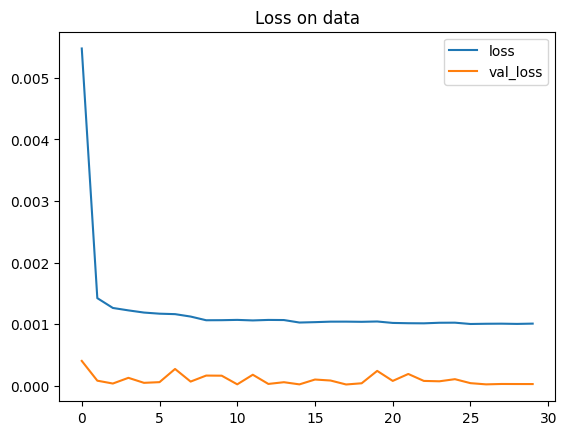

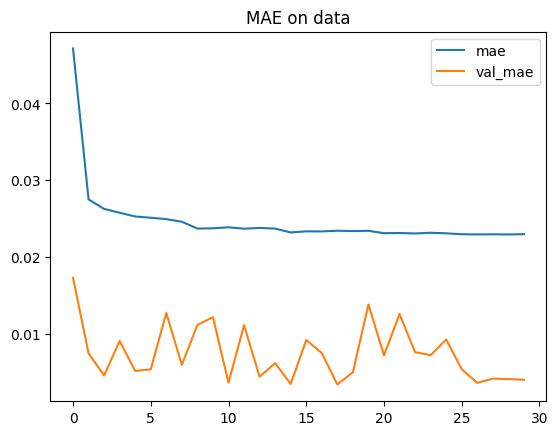

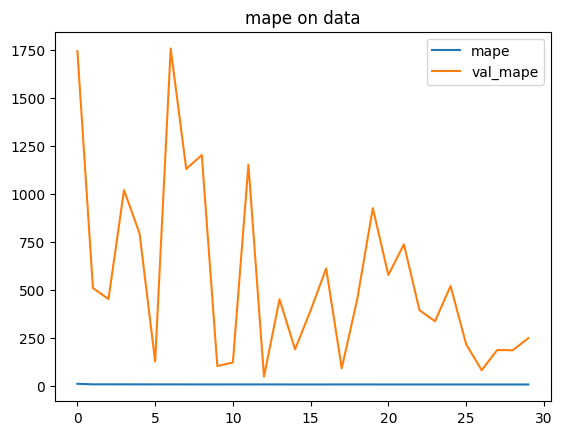

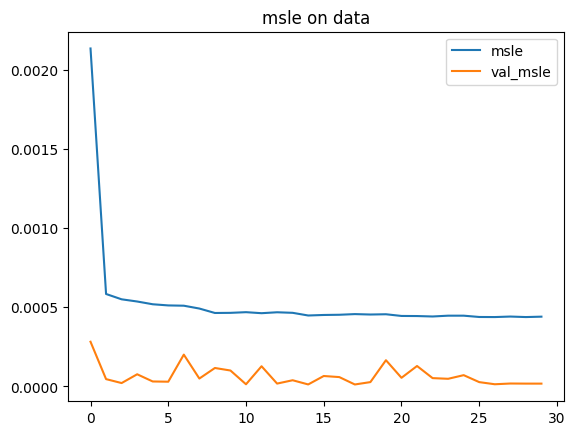

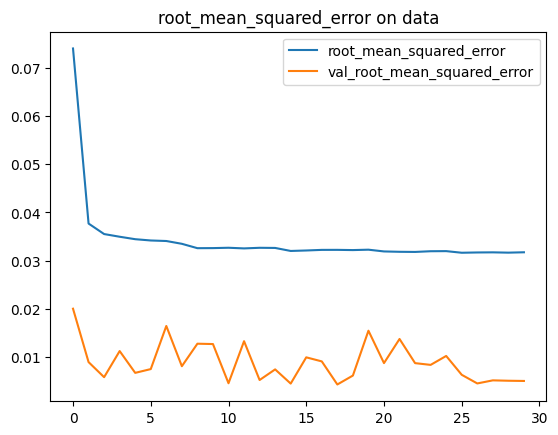

In [ ]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [44]:
best_model = load_model(m_label + 'lstm_best.keras')


In [45]:
y_pred = best_model.predict(X_test)

11/11 [==============================] - 3s 108ms/step


In [46]:
print(y_pred.shape)

(330, 5)


In [47]:
_,y_test = inverse_transform_data(scaled_y=y_test)
_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[1.18002 1.1806  1.18145 1.1804  1.18053]
 [1.1806  1.18145 1.1804  1.18053 1.17973]
 [1.18145 1.1804  1.18053 1.17973 1.17982]
 ...
 [1.15781 1.16123 1.16054 1.16007 1.16082]
 [1.16123 1.16054 1.16007 1.16082 1.16123]
 [1.16054 1.16007 1.16082 1.16123 1.16159]]  comparing to  [[1.1782933 1.178247  1.1782197 1.1782503 1.1781894]
 [1.178196  1.1781496 1.1781223 1.1781529 1.1780921]
 [1.1786116 1.1785653 1.1785382 1.1785686 1.1785074]
 ...
 [1.154857  1.1548136 1.154773  1.1548158 1.1547687]
 [1.1559947 1.1559511 1.1559112 1.1559533 1.1559057]
 [1.1592828 1.1592388 1.1592009 1.1592412 1.1591914]]


In [ ]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")

In [48]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred_corrected))

R^2 value for  GeneratedEURUSD 
0.8683281000366614


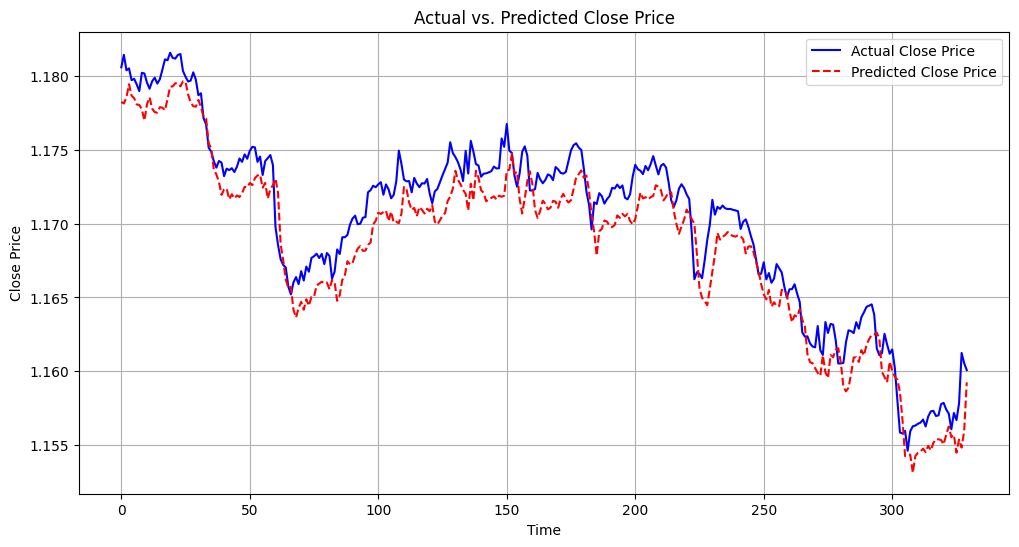

In [ ]:




plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual Close Price', color='blue')
plt.plot(y_pred[:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()
